# Demonstration 4: Decision Tree

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sisyphus.envs import DecisionTree
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
img_dir = os.path.join('..','figures')
%matplotlib inline

## Value Iteration

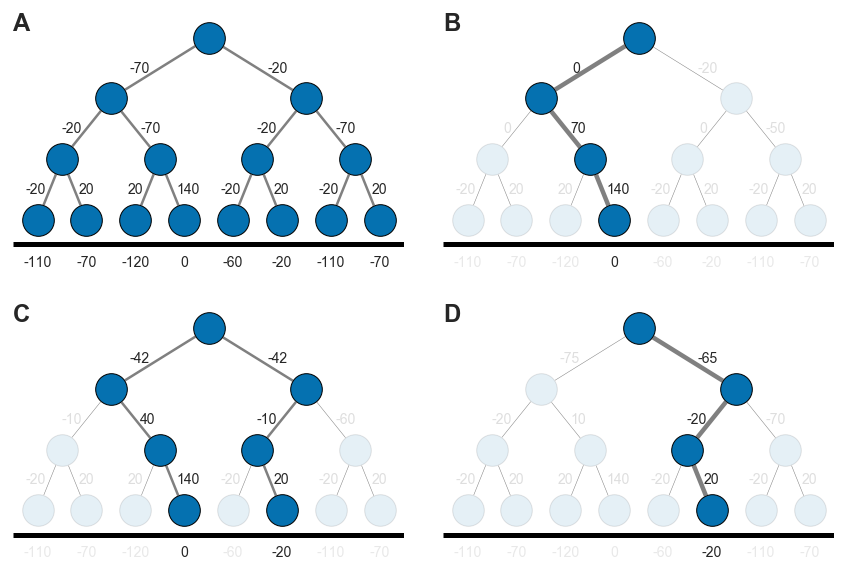

In [2]:
from sisyphus.mdp import ValueIteration
from sisyphus.mdp._misc import softmax
from palettable.colorbrewer.diverging import RdBu_5 as palette

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
weights = [1.0, 0.75, 0.5]

## Visualization parameters.
vmin, vmax = -24, 0
inv_temp = 10

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Value Iteration.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = DecisionTree()

## Preallocate space.
V = np.zeros((len(weights), gym.n_states))
theta_v = np.zeros_like(V)
Q = np.zeros((len(weights), gym.info.shape[0]))
theta_q = np.zeros_like(Q)

for i, w in enumerate(weights):
    
    ## Initialize value iteration.
    qvi = ValueIteration(policy='pessimism', gamma=1.0, w=w)
    
    ## Solve for Q-values.
    qvi  = qvi.fit(gym)
    Q[i] = qvi.Q.copy()
    
    ## Solve for state values.
    V[i] = qvi.V.copy()
    
    ## This next section is used to calculate edge weights for
    ## visualization. Weights are a function of the likelihood
    ## of taking a certain action, as computed via the softmax.
    info = gym.info.copy()
    info["S'"] = info["S'"].apply(lambda arr: arr[0])

    ## Copy Q-values.
    info['Q'] = qvi.Q

    ## Copy likelihood of action.
    info['theta'] = info.groupby('S').Q.apply(lambda arr: softmax(arr * inv_temp))

    ## Compute joint-likelihood.
    for a in range(sum(info["S"] != info["S'"])):    
        info.loc[info['S'] == info.loc[a,"S'"],'theta'] *= info.loc[a,'theta']
    
    ## Store values.
    theta_q[i] = info.theta.values.copy()         # Joint likelihood of action.
    theta_v[i] = info.groupby('S').theta.max()    # Joint likelihood of state.
    
## Fill in terminal states.
V[:,-8:] = [-20, 20, 20, 140, -20, 20, -20, 20]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize figure.
fig = plt.figure(figsize=(12,8))
colors = palette.hex_colors

## Initialize plots and divider.
gs = gridspec.GridSpec(2,2)
gs.update(left=0.025, right=0.975, bottom=0.05, top=0.975, hspace=0.2, wspace=0.1)
axes = [plt.subplot(gs[i//2,i%2]) for i in range(4)]

## Plot environment.
gym.plot_decision_tree(color=colors[-1], edge_width=2.5, edge_labels=True, path_sums=True, ax=axes[0])
axes[0].annotate('A', (0,0), (0,1), 'axes fraction', va='top', ha='left', 
                 fontsize=24, fontweight='bold')

## Define plot features.
alpha = np.where(theta_v < 0.5, 0.1, 1)    # Node transparency.
edge_width = np.copy(theta_q) * 4 + 0.5     # Edge line widths.
ela = np.where(theta_q < 0.5, 0.15, 1)      # Edge label transparency.

## Iteratively plot.
for i, (w, letter) in enumerate(zip(weights, ['B','C','D'])):
    
    ## Plot value map.
    ax = gym.plot_decision_tree(color=colors[-1],alpha=alpha[i], edge_width=edge_width[i], 
                                edge_labels=Q[i,:14], edge_label_alpha=ela[i], ax=axes[i+1])
    axes[i+1].annotate(letter, (0,0), (0,1), 'axes fraction', va='top', ha='left', 
                       fontsize=24, fontweight='bold')
    
plt.savefig(os.path.join(img_dir, '04_tree.png'), dpi=180)

## RLDM 2019 (Condensed Figure)

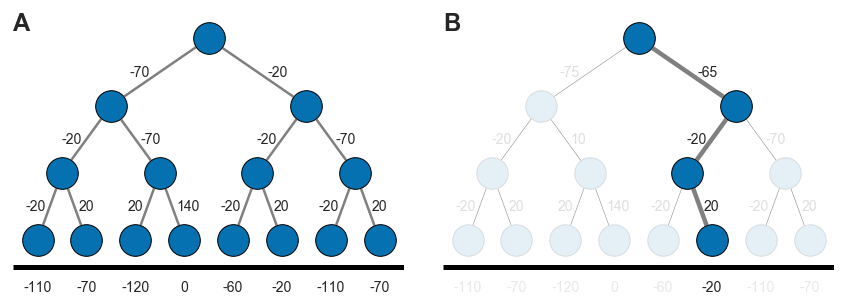

In [3]:
from sisyphus.mdp import ValueIteration
from sisyphus.mdp._misc import softmax
from palettable.colorbrewer.diverging import RdBu_5 as palette

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
w = 0.5

## Visualization parameters.
vmin, vmax = -24, 0
inv_temp = 10

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Value Iteration.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize environment.
gym = DecisionTree()
    
## Initialize value iteration.
qvi = ValueIteration(policy='pessimism', gamma=1.0, w=w)

## Solve for Q-values.
qvi  = qvi.fit(gym)
Q = qvi.Q.copy()

## Solve for state values.
V = qvi.V.copy()

## This next section is used to calculate edge weights for
## visualization. Weights are a function of the likelihood
## of taking a certain action, as computed via the softmax.
info = gym.info.copy()
info["S'"] = info["S'"].apply(lambda arr: arr[0])

## Copy Q-values.
info['Q'] = qvi.Q

## Copy likelihood of action.
info['theta'] = info.groupby('S').Q.apply(lambda arr: softmax(arr * inv_temp))

## Compute joint-likelihood.
for a in range(sum(info["S"] != info["S'"])):    
    info.loc[info['S'] == info.loc[a,"S'"],'theta'] *= info.loc[a,'theta']

## Store values.
theta_q = info.theta.values.copy()         # Joint likelihood of action.
theta_v = info.groupby('S').theta.max()    # Joint likelihood of state.
    
## Fill in terminal states.
V[-8:] = [-20, 20, 20, 140, -20, 20, -20, 20]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize figure.
fig = plt.figure(figsize=(12,4))
colors = palette.hex_colors

## Initialize plots and divider.
gs = gridspec.GridSpec(1,2)
gs.update(left=0.025, right=0.975, bottom=0.05, top=0.975, hspace=0.2, wspace=0.1)

## Plot environment.
ax = plt.subplot(gs[0])
gym.plot_decision_tree(color=colors[-1], edge_width=2.5, edge_labels=True, path_sums=True, ax=ax)
ax.annotate('A', (0,0), (0,1), 'axes fraction', va='top', ha='left', 
            fontsize=24, fontweight='bold')

## Define plot features.
alpha = np.where(theta_v < 0.5, 0.1, 1)    # Node transparency.
edge_width = np.copy(theta_q) * 4 + 0.5     # Edge line widths.
ela = np.where(theta_q < 0.5, 0.15, 1)      # Edge label transparency.
    
## Plot value map.
ax = plt.subplot(gs[1])
ax = gym.plot_decision_tree(color=colors[-1],alpha=alpha, edge_width=edge_width, 
                            edge_labels=Q[:14], edge_label_alpha=ela, ax=ax)
ax.annotate('B', (0,0), (0,1), 'axes fraction', va='top', ha='left', 
            fontsize=24, fontweight='bold')
    
plt.savefig(os.path.join(img_dir, '04_tree_rldm.png'), dpi=180)